In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [32]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [33]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display

In [34]:
# add our package dir to path
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [35]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
NVIDIA GeForce RTX 3090 Ti


In [36]:
class PartialDataset(Dataset):
    def __init__(self, dataset, n_items=10):
        self.dataset = dataset
        self.n_items = n_items

    def __getitem__(self):
        return self.dataset.__getitem__()

    def __len__(self):
        return min(self.n_items, len(self.dataset))

In [37]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize
    ])
val_transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize
     ])

dataset_train = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = datasets.CIFAR10(root='../data/', train=False, download=True, transform=val_transform)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)


n_items = 10
dataset_train_part = PartialDataset(dataset_train, n_items)
train_loader_part = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor([[[-0.7333, -0.7412, -0.7490,  ..., -0.8039, -0.8039, -0.7961],
         [-0.7333, -0.7333, -0.7412,  ..., -0.8039, -0.8039, -0.7961],
         [-0.7176, -0.7255, -0.7333,  ..., -0.7961, -0.8118, -0.7961],
         ...,
         [ 0.0196, -0.0039, -0.0353,  ...,  0.2157,  0.2000, -0.0196],
         [ 0.0588,  0.0196, -0.0118,  ..., -0.0431,  0.3882,  0.4118],
         [ 0.0980,  0.0588,  0.0353,  ..., -0.2549, -0.1529,  0.1373]],

        [[-0.7725, -0.7725, -0.7804,  ..., -0.8353, -0.8353, -0.8275],
         [-0.7647, -0.7647, -0.7725,  ..., -0.8353, -0.8353, -0.8275],
         [-0.7490, -0.7569, -0.7647,  ..., -0.8275, -0.8431, -0.8275],
         ...,
         [-0.2314, -0.2549, -0.2784,  ..., -0.1686, -0.1137, -0.2706],
         [-0.2078, -0.2392, -0.2706,  ..., -0.3647, -0.0667, -0.0824],
         [-0.1765, -0.2157, -0.2471,  ..., -0.5059, -0.4431, -0.2392]],

        [[-0.7961, -0.7961, -0.8039,  ..., -0.8588, -0.8588, -0.8510],
         [-0.7882, -0.7882, -0.7961,  ..., -0

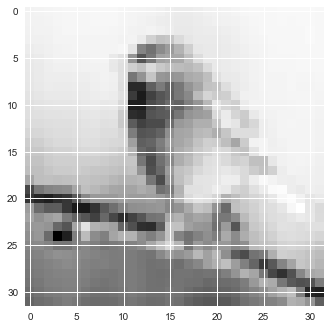

In [38]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    label = X
    target = y
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [39]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()

    return parameters_n

In [40]:
class VGG_A(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x

class VGG_A_Batch(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x

class VGG_A_Light(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        '''
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        '''
        self.classifier = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        #x = self.stage3(x)
        #x = self.stage4(x)
        #x = self.stage5(x)
        x = self.classifier(x.view(-1, 32*8*8))
        return x


class VGG_A_Dropout(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512*1*1, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.classifier(x.view(-1, 512*1*1))
        return x

class VGG_A_Layer(nn.Module):
    def __init__(self,shape, inp_ch=3, num_classes=10):
        super().__init__()
        self.shape = shape

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.LayerNorm([64] + list(self.shape[1:])),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LayerNorm([128, self.shape[1] // 2, self.shape[2] // 2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.LayerNorm([256, self.shape[1] // 4, self.shape[2] // 4]),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.LayerNorm([256, self.shape[1] // 4, self.shape[2] // 4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, self.shape[1] // 8, self.shape[2] // 8]),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, self.shape[1] // 8, self.shape[2] // 8]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, self.shape[1] // 16, self.shape[2] // 16]),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, self.shape[1] // 16, self.shape[2] // 16]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x

print(get_number_of_parameters(VGG_A()))

9750922


In [41]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [42]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [43]:
def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          scheduler=None,
          epochs_n=100,
          best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    losses_list = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()
        loss_list = []
        learning_curve[epoch] = 0
        for data in train_loader:

            #print(data)

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        losses_list.append(loss_list)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return losses_list

In [44]:
epo = 20

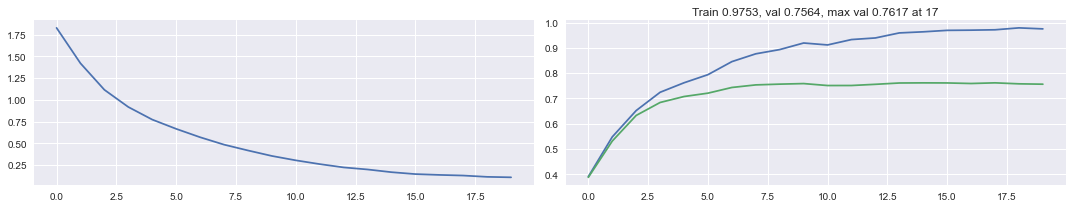

100%|██████████| 20/20 [08:38<00:00, 25.92s/epoch]


In [15]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

loss_01 = train(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                epochs_n=epo)

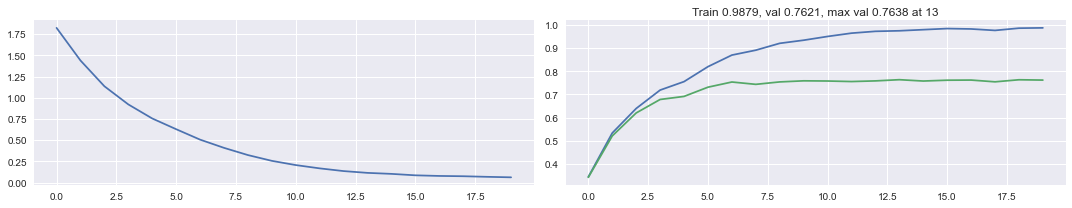

100%|██████████| 20/20 [08:42<00:00, 26.13s/epoch]


In [16]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_005 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)

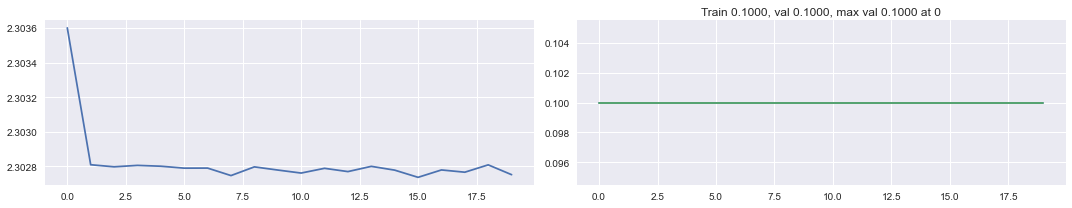

100%|██████████| 20/20 [08:25<00:00, 25.29s/epoch]


In [17]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_02 = train(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                epochs_n=epo)

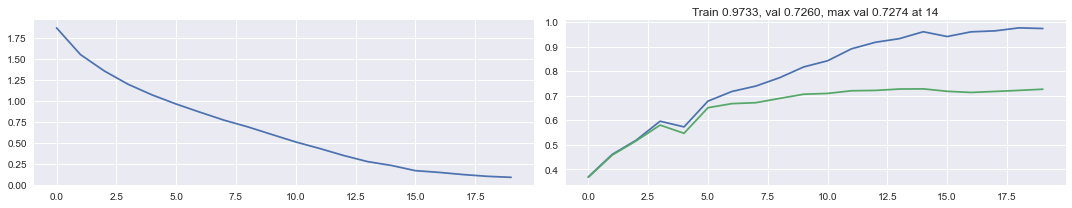

100%|██████████| 20/20 [08:28<00:00, 25.45s/epoch]


In [18]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


loss_001 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)


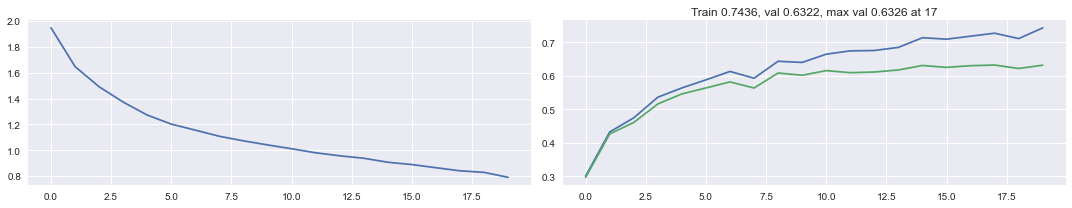

100%|██████████| 20/20 [08:36<00:00, 25.81s/epoch]


In [19]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

loss_03 = train(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                epochs_n=epo)

In [20]:
#import itertools
loss_01 = np.array(loss_01).flatten()
loss_03 = np.array(loss_03).flatten()
loss_005 = np.array(loss_005).flatten()
loss_001 = np.array(loss_001).flatten()
min_curve = []
max_curve = []
for i in range(len(loss_01)):
    min_curve.append(np.min([loss_01[i], loss_03[i], loss_005[i], loss_001[i]]))
    max_curve.append(np.max([loss_01[i], loss_03[i], loss_005[i], loss_001[i]]))

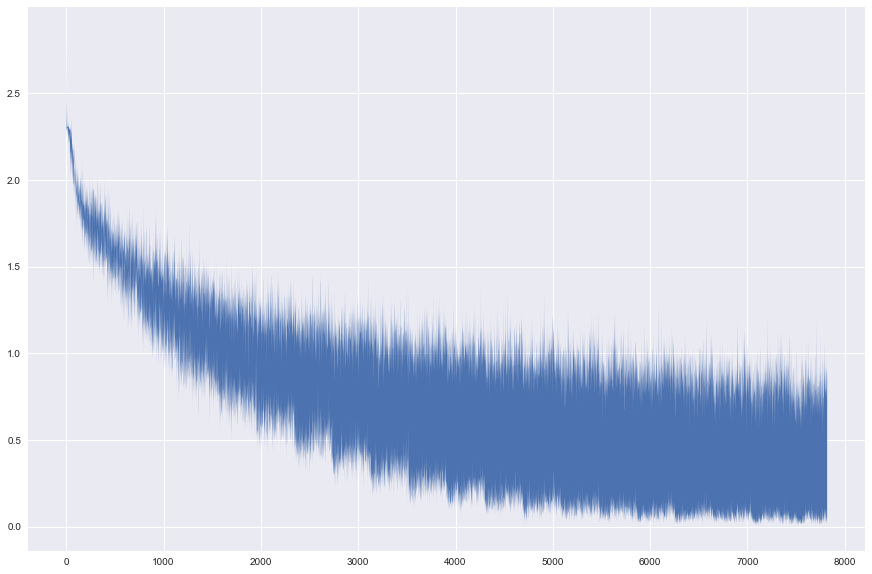

In [21]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)), min_curve, max_curve)

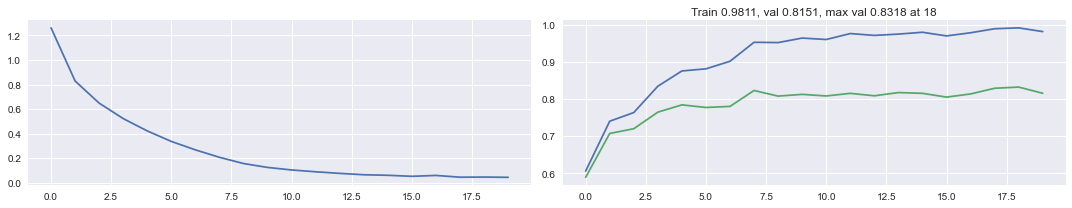

100%|██████████| 20/20 [09:17<00:00, 27.86s/epoch]


In [22]:
plt.fill_between(range(len(min_curve)), min_curve, max_curve)
os.path.join(os.getcwd(), 'best_vgg_1.pt')  #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_batch_01 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

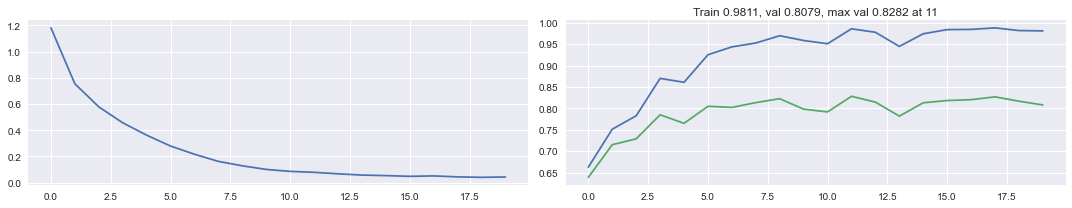

100%|██████████| 20/20 [09:24<00:00, 28.21s/epoch]


In [23]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_batch_005 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)


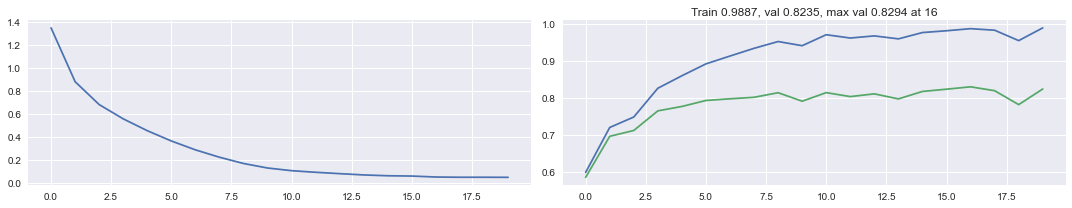

100%|██████████| 20/20 [09:35<00:00, 28.78s/epoch]


In [24]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_batch_02 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)


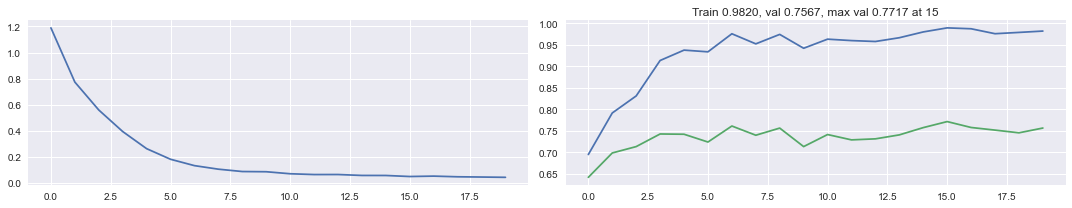

100%|██████████| 20/20 [09:25<00:00, 28.28s/epoch]


In [25]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_batch_001 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)


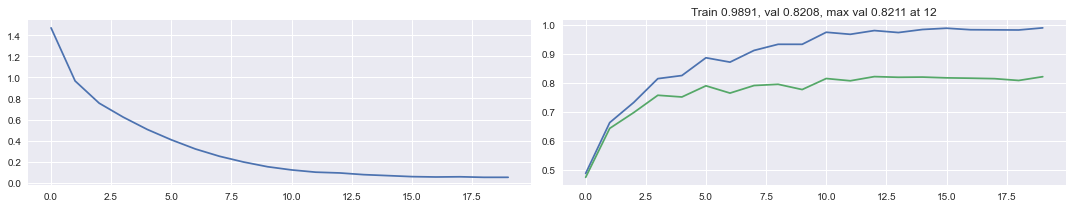

100%|██████████| 20/20 [09:19<00:00, 27.98s/epoch]


In [26]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_batch_03 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

In [27]:
loss_batch_01 = np.array(loss_batch_01).flatten()
loss_batch_03 = np.array(loss_batch_03).flatten()
loss_batch_005 = np.array(loss_batch_005).flatten()
loss_batch_001 = np.array(loss_batch_001).flatten()
min_curve_batch = []
max_curve_batch = []
for i in range(len(loss_01)):
    min_curve_batch.append(np.min([loss_batch_01[i], loss_batch_03[i], loss_batch_005[i], loss_batch_001[i]]))
    max_curve_batch.append(np.max([loss_batch_01[i], loss_batch_03[i], loss_batch_005[i], loss_batch_001[i]]))

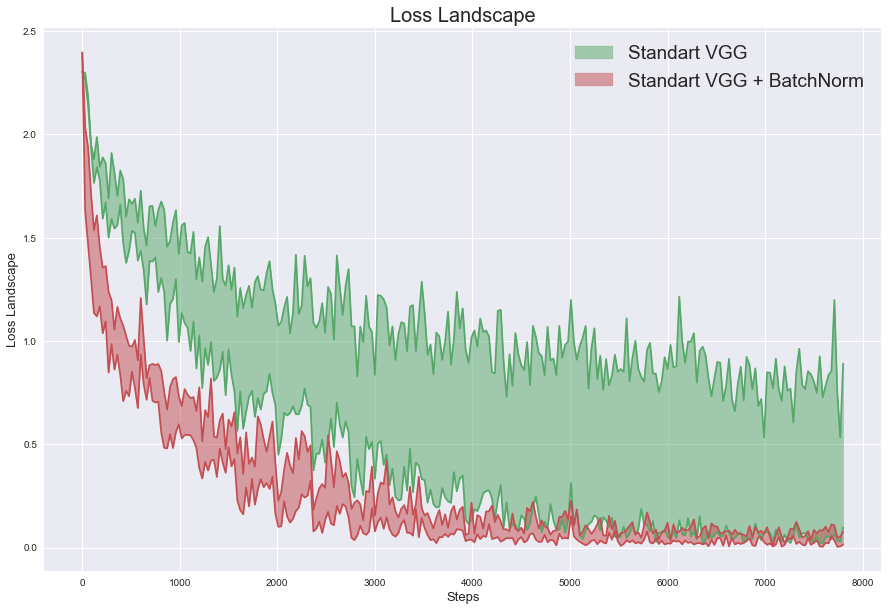

In [28]:
step = 30
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                 alpha=0.5, color='C1', label='Standart VGG')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_curve_batch[::step], max_curve_batch[::step],
                 alpha=0.5, color='C2', label='Standart VGG + BatchNorm')
plt.plot(steps, min_curve_batch[::step], color='C2')
plt.plot(steps, max_curve_batch[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Loss Landscape', fontsize=20)
plt.ylabel('Loss Landscape', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join('loss_landscape.png'), dpi=500, quality=100)
plt.show()

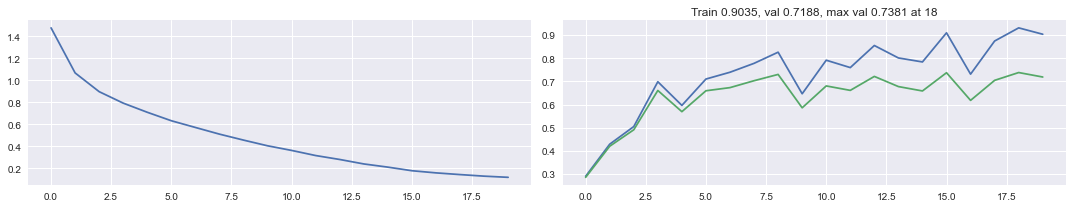

100%|██████████| 20/20 [10:13<00:00, 30.66s/epoch]


In [46]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Layer(label[0].shape)
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_01 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

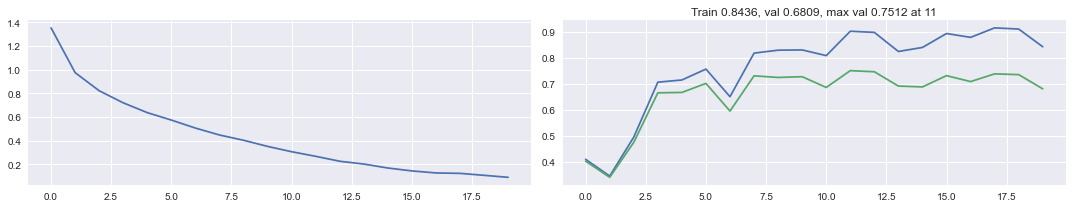

100%|██████████| 20/20 [10:07<00:00, 30.38s/epoch]


In [47]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Layer(label[0].shape)
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_005 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

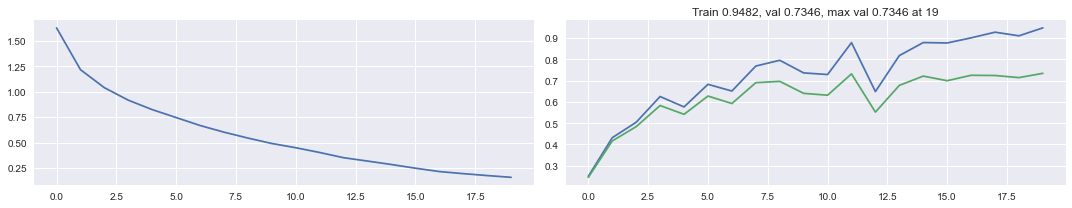

100%|██████████| 20/20 [10:09<00:00, 30.49s/epoch]


In [48]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Layer(label[0].shape)
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_02 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)

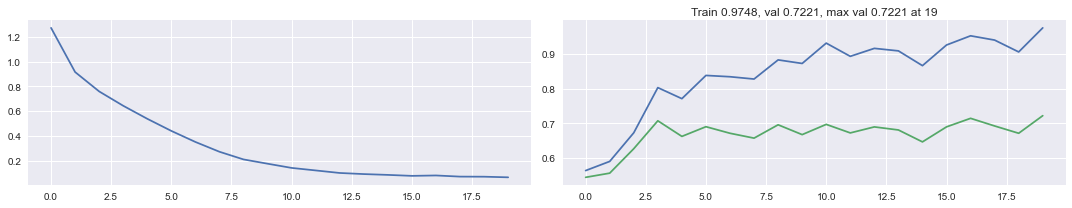

100%|██████████| 20/20 [10:26<00:00, 31.31s/epoch]


In [49]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Layer(label[0].shape)
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_001 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)

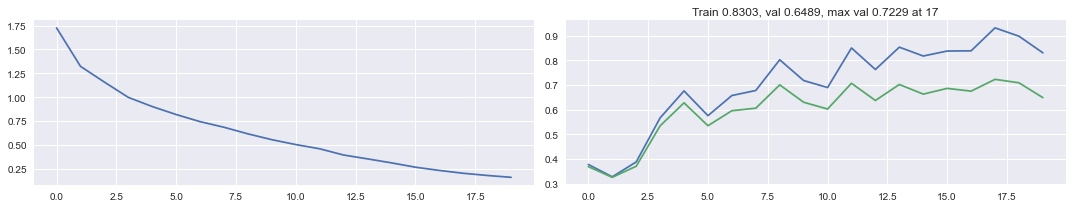

100%|██████████| 20/20 [10:15<00:00, 30.78s/epoch]


In [50]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Layer(label[0].shape)
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_03 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)